# Unsupervised Clustering - Student Segmentation

## Objective
Segment students into distinct learning personas using K-Means clustering based on behavioural features.

## CRISP-DM Stage
Modelling and Evaluation

## Methods
- Feature selection and standardisation
- Elbow Method for optimal k determination
- Silhouette Score analysis
- K-Means clustering
- PCA visualisation
- Cluster profiling

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('All libraries imported successfully')
print('=' * 80)

All libraries imported successfully


## Section 1: Load and Prepare Clustering Features

Select and standardise behavioural features for clustering.

In [50]:
print('\n' + '=' * 80)
print('CLUSTERING: FEATURE PREPARATION')
print('=' * 80)

df_encoded = pd.read_pickle('../2_Outputs/df_encoded_full.pkl')

clustering_features = [
    'total_clicks', 'avg_clicks_per_day', 'avg_clicks_per_week', 
    'days_active', 'late_clicks',
    'score_mean', 'submit_delay_mean', 'num_late_submissions',
    'num_assessments', 'target_score'
]

clustering_features = [col for col in clustering_features if col in df_encoded.columns]
print(f'Clustering features selected ({len(clustering_features)}): {clustering_features}')

X_clustering = df_encoded[clustering_features].fillna(0)

print(f'\nClustering dataset shape: {X_clustering.shape}')
print(f'Feature statistics:')
print(X_clustering.describe())

scaler = StandardScaler()
X_clustering_scaled = scaler.fit_transform(X_clustering)

print(f'\nScaled features shape: {X_clustering_scaled.shape}')


CLUSTERING: FEATURE PREPARATION
Clustering features selected (10): ['total_clicks', 'avg_clicks_per_day', 'avg_clicks_per_week', 'days_active', 'late_clicks', 'score_mean', 'submit_delay_mean', 'num_late_submissions', 'num_assessments', 'target_score']

Clustering dataset shape: (23436, 10)
Feature statistics:
       total_clicks  avg_clicks_per_day  avg_clicks_per_week   days_active  \
count  23436.000000        23436.000000         23436.000000  23436.000000   
mean    1617.393066            2.877880            48.936199    432.955719   
std     1830.673462            1.215301            47.742493    389.615784   
min        0.000000            0.000000             0.000000      0.000000   
25%      422.000000            2.000000            17.644520    150.000000   
50%      997.000000            3.000000            34.026447    316.000000   
75%     2151.000000            4.000000            64.077909    596.000000   
max    24139.000000           20.000000           652.684204   

## Section 2: Determine Optimal Clusters - Elbow Method

Identify optimal number of clusters by analysing within-cluster sum of squares.


ELBOW METHOD FOR OPTIMAL K
k=2: Inertia = 150376.6875
k=3: Inertia = 118374.1406
k=4: Inertia = 102470.6250
k=5: Inertia = 91052.0859
k=6: Inertia = 84375.5781
k=7: Inertia = 77945.7812
k=8: Inertia = 72239.5078
k=9: Inertia = 67948.2500
k=10: Inertia = 64845.1953


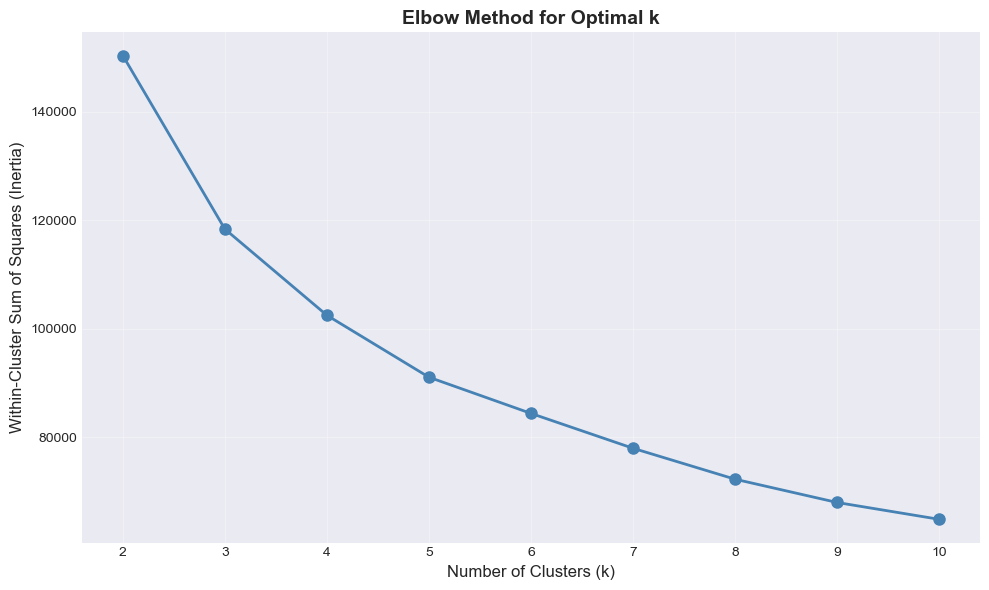

In [51]:
print('\n' + '=' * 80)
print('ELBOW METHOD FOR OPTIMAL K')
print('=' * 80)

inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_clustering_scaled)
    inertias.append(kmeans.inertia_)
    print(f'k={k}: Inertia = {kmeans.inertia_:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o', linestyle='-', linewidth=2, markersize=8, color='steelblue')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (Inertia)', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

## Section 3: Determine Optimal Clusters - Silhouette Score

Evaluate cluster quality using Silhouette Score analysis.


SILHOUETTE SCORE FOR OPTIMAL K
k=2: Silhouette Score = 0.3260
k=3: Silhouette Score = 0.2571
k=4: Silhouette Score = 0.2536
k=5: Silhouette Score = 0.2617
k=6: Silhouette Score = 0.2410
k=7: Silhouette Score = 0.2377
k=8: Silhouette Score = 0.2490
k=9: Silhouette Score = 0.2496
k=10: Silhouette Score = 0.2392

Optimal k (based on Silhouette Score): 2


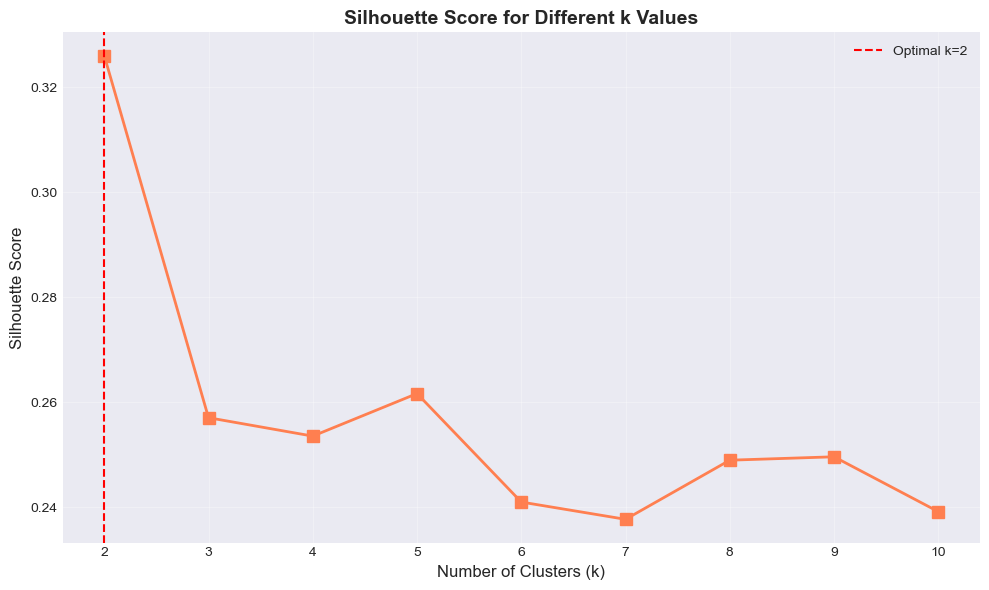


Selected k: 4


In [58]:
print('\n' + '=' * 80)
print('SILHOUETTE SCORE FOR OPTIMAL K')
print('=' * 80)

silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_clustering_scaled)
    silhouette_avg = silhouette_score(X_clustering_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f'k={k}: Silhouette Score = {silhouette_avg:.4f}')

optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f'\nOptimal k (based on Silhouette Score): {optimal_k_silhouette}')

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='s', linestyle='-', linewidth=2, markersize=8, color='coral')
plt.axvline(x=optimal_k_silhouette, color='red', linestyle='--', label=f'Optimal k={optimal_k_silhouette}')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score for Different k Values', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.legend()
plt.tight_layout()
plt.show()

optimal_k = 4
print(f'\nSelected k: {optimal_k}')

## Section 4: K-Means Clustering

Implement K-Means with optimal number of clusters.

In [59]:
print('\n' + '=' * 80)
print('K-MEANS CLUSTERING')
print('=' * 80)

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_clustering_scaled)

df_encoded['cluster'] = cluster_labels

print(f'K-Means converged in {kmeans_final.n_iter_} iterations')
print(f'\nCluster Distribution:')
print(df_encoded['cluster'].value_counts().sort_index())

silhouette_avg = silhouette_score(X_clustering_scaled, cluster_labels)
print(f'\nSilhouette Score (final model): {silhouette_avg:.4f}')

sample_silhouette_values = silhouette_samples(X_clustering_scaled, cluster_labels)
print(f'Average sample Silhouette Value: {sample_silhouette_values.mean():.4f}')


K-MEANS CLUSTERING
K-Means converged in 10 iterations

Cluster Distribution:
cluster
0    7386
1    3674
2    5423
3    6953
Name: count, dtype: int64

Silhouette Score (final model): 0.2536
Average sample Silhouette Value: 0.2536


## Section 5: PCA Visualisation

Reduce dimensions to 2D for cluster visualisation.


PCA DIMENSIONALITY REDUCTION
PCA Explained Variance Ratio: [0.45078403 0.20001566]
Total Variance Explained: 0.6508


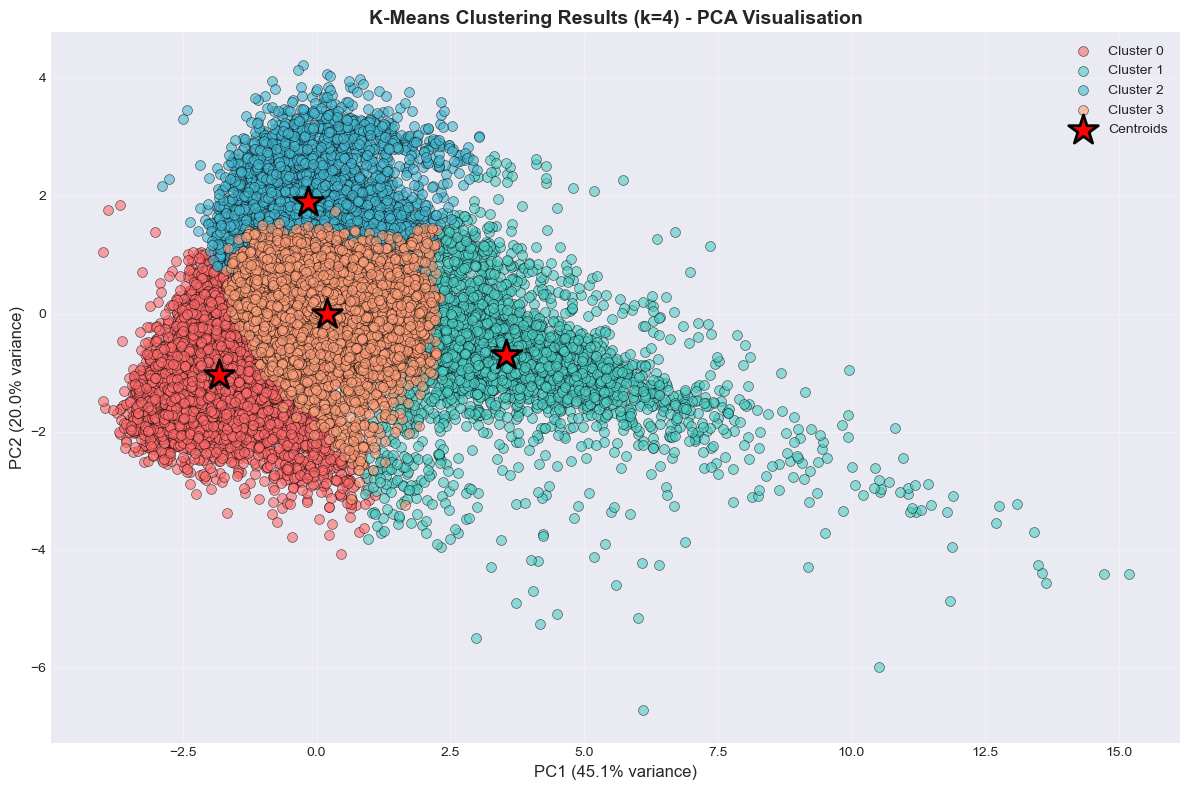

In [60]:
print('\n' + '=' * 80)
print('PCA DIMENSIONALITY REDUCTION')
print('=' * 80)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clustering_scaled)

print(f'PCA Explained Variance Ratio: {pca.explained_variance_ratio_}')
print(f'Total Variance Explained: {pca.explained_variance_ratio_.sum():.4f}')

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = cluster_labels

# Transform centroids for visualisation
centroids_pca = pca.transform(kmeans_final.cluster_centers_)

# Create scatter plot
plt.figure(figsize=(12, 8))

colours = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
for i in range(optimal_k):
    mask = cluster_labels == i
    plt.scatter(
        X_pca[mask, 0], X_pca[mask, 1],
        c=colours[i % len(colours)],
        label=f'Cluster {i}',
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    c='red', marker='*', s=500,
    label='Centroids',
    edgecolors='black',
    linewidth=2
)

colours_for_legend = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title(f'K-Means Clustering Results (k={optimal_k}) - PCA Visualisation', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Section 6: Cluster Profiling

Analyse cluster characteristics and create learning personas.


CLUSTER PROFILING AND INTERPRETATION

Cluster Profiles (Mean Feature Values):
         total_clicks  avg_clicks_per_day  avg_clicks_per_week  days_active  \
cluster                                                                       
0          453.107208              2.4996            27.749201   145.373795   
1         4861.763672              4.1255           130.834793  1069.213135   
2         1077.113281              2.4121            29.839001   361.470001   
3         1561.235840              2.9837            43.061901   458.000610   

         late_clicks  score_mean  submit_delay_mean  num_late_submissions  \
cluster                                                                     
0                0.0   61.954300          -4.103400                1.1041   
1                0.0   81.299103         -42.666698                1.1345   
2                0.0   76.515999           1.060900                5.5707   
3                0.0   76.397499          -8.371800          

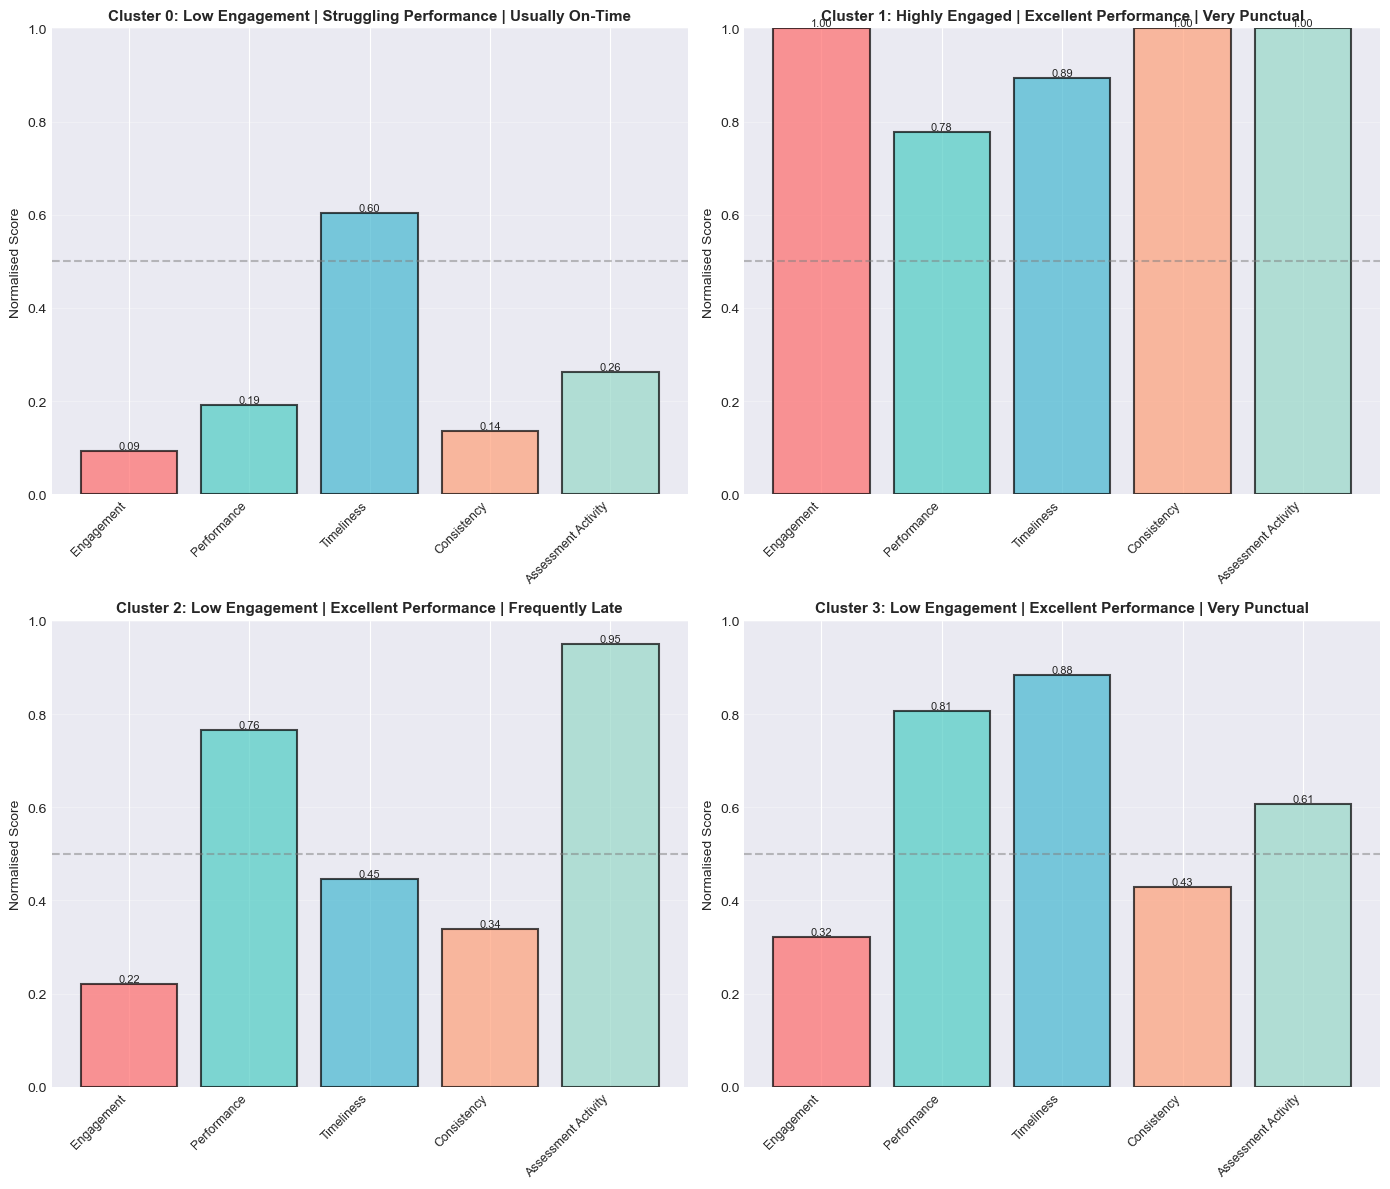

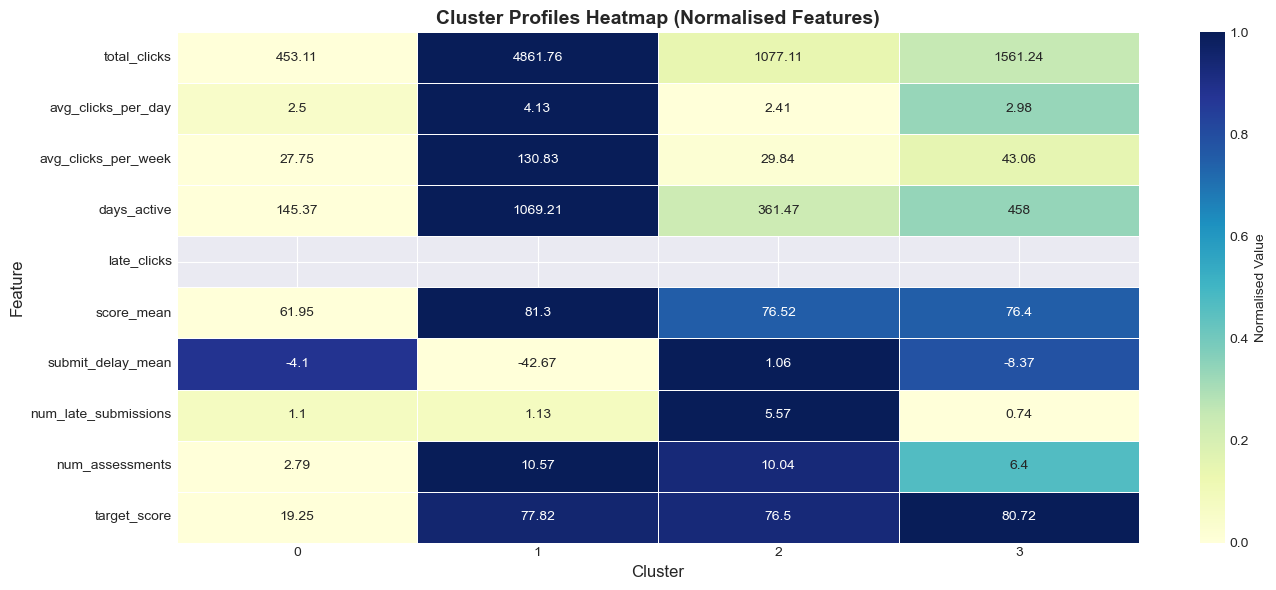


Clustering results saved for final notebook


In [61]:
print('\n' + '=' * 80)
print('CLUSTER PROFILING AND INTERPRETATION')
print('=' * 80)

cluster_profiles = df_encoded.groupby('cluster')[clustering_features].mean()

print('\nCluster Profiles (Mean Feature Values):')
print('=' * 80)
print(cluster_profiles.round(4))

# Create comprehensive learning personas
cluster_personas = {}
for cluster_id in range(optimal_k):
    profile = cluster_profiles.loc[cluster_id]
    
    # Engagement metrics (using percentile approach for nuance)
    total_clicks_q = (profile['total_clicks'] - cluster_profiles['total_clicks'].min()) / (cluster_profiles['total_clicks'].max() - cluster_profiles['total_clicks'].min())
    avg_clicks_per_day_q = (profile['avg_clicks_per_day'] - cluster_profiles['avg_clicks_per_day'].min()) / (cluster_profiles['avg_clicks_per_day'].max() - cluster_profiles['avg_clicks_per_day'].min())
    
    # Performance metrics
    performance_q = (profile['target_score'] - cluster_profiles['target_score'].min()) / (cluster_profiles['target_score'].max() - cluster_profiles['target_score'].min())
    
    # Timeliness and submission behaviour
    submission_delay_q = (profile['submit_delay_mean'] - cluster_profiles['submit_delay_mean'].min()) / (cluster_profiles['submit_delay_mean'].max() - cluster_profiles['submit_delay_mean'].min())
    late_submission_rate = profile['num_late_submissions'] / profile['num_assessments'] if profile['num_assessments'] > 0 else 0
    
    # Activity consistency
    days_active_q = (profile['days_active'] - cluster_profiles['days_active'].min()) / (cluster_profiles['days_active'].max() - cluster_profiles['days_active'].min())
    
    # Assessment engagement (ratio of assessments to activity)
    assessment_participation = profile['num_assessments'] / (cluster_profiles['num_assessments'].max())
    
    # Categorise engagement levels (3-tier for more nuance)
    if total_clicks_q >= 0.67:
        engagement_level = 'Highly Engaged'
    elif total_clicks_q >= 0.33:
        engagement_level = 'Moderately Engaged'
    else:
        engagement_level = 'Low Engagement'
    
    # Categorise performance (4-tier)
    if performance_q >= 0.75:
        performance_level = 'Excellent'
    elif performance_q >= 0.5:
        performance_level = 'Good'
    elif performance_q >= 0.25:
        performance_level = 'Moderate'
    else:
        performance_level = 'Struggling'
    
    # Categorise timeliness (considering both delay and late submissions)
    on_time_rate = 1 - late_submission_rate
    if on_time_rate >= 0.8:
        timeliness = 'Very Punctual'
    elif on_time_rate >= 0.6:
        timeliness = 'Usually On-Time'
    elif on_time_rate >= 0.4:
        timeliness = 'Frequently Late'
    else:
        timeliness = 'Chronically Late'
    
    # Identify risk factors
    risk_factors = []
    if performance_q < 0.4:
        risk_factors.append('at-risk academically')
    if late_submission_rate > 0.4:
        risk_factors.append('poor deadline management')
    if total_clicks_q < 0.4:
        risk_factors.append('low platform engagement')
    if days_active_q < 0.4:
        risk_factors.append('inconsistent attendance')
    
    # Identify strengths
    strengths = []
    if total_clicks_q >= 0.65:
        strengths.append('highly engaged with materials')
    if avg_clicks_per_day_q >= 0.65:
        strengths.append('consistent daily engagement')
    if performance_q >= 0.65:
        strengths.append('strong academic performance')
    if on_time_rate >= 0.8:
        strengths.append('excellent time management')
    if days_active_q >= 0.65:
        strengths.append('regular attendance pattern')
    
    # Create persona name with more detail
    persona_name = f'{engagement_level} | {performance_level} Performance | {timeliness}'
    
    cluster_personas[cluster_id] = {
        'name': persona_name,
        'engagement_level': engagement_level,
        'performance_level': performance_level,
        'timeliness': timeliness,
        'on_time_rate': on_time_rate,
        'risk_factors': risk_factors,
        'strengths': strengths,
        'avg_score': profile['target_score'],
        'avg_clicks': profile['total_clicks'],
        'avg_days_active': profile['days_active'],
        'avg_clicks_per_day': profile['avg_clicks_per_day'],
        'num_assessments': profile['num_assessments'],
        'submit_delay': profile['submit_delay_mean']
    }

print('\n\nDetailed Learning Personas:')
print('=' * 80)
for cluster_id, persona in cluster_personas.items():
    count = (cluster_labels == cluster_id).sum()
    pct = count / len(cluster_labels) * 100
    print(f'\nCLUSTER {cluster_id}: {persona["name"]}')
    print(f'   Population: {count} students ({pct:.1f}%)')
    print(f'   ─────────────────────────────────────────')
    print(f'   Academic Performance: {persona["avg_score"]:.1f}/100 ({persona["performance_level"]})')
    print(f'   Platform Engagement: {persona["avg_clicks"]:.0f} total clicks ({persona["avg_clicks_per_day"]:.1f}/day)')
    print(f'   Active Period: {persona["avg_days_active"]:.1f} days')
    print(f'   Assessment Participation: {persona["num_assessments"]:.1f} submissions')
    print(f'   Submission Timeliness: {persona["on_time_rate"]:.1%} on-time ({persona["submit_delay"]:.1f} day avg delay)')
    
    if persona['strengths']:
        print(f'   Key Strengths: {"; ".join(persona["strengths"])}')
    
    if persona['risk_factors']:
        print(f'   Intervention Needed: {"; ".join(persona["risk_factors"])}')
    
    print(f'   Support Level: ', end='')
    if len(persona['risk_factors']) > 2:
        print(f'HIGH PRIORITY ({len(persona["risk_factors"])} risk factors)')
    elif persona['risk_factors']:
        print(f'MEDIUM PRIORITY ({len(persona["risk_factors"])} risk factor)')
    elif persona['performance_level'] in ['Excellent', 'Good']:
        print('MINIMAL (high performer)')
    else:
        print('MEDIUM PRIORITY (moderate support)')

# Create persona comparison radar chart
print('\n' + '=' * 80)
print('PERSONA CHARACTERISTIC COMPARISON')
print('=' * 80)

# Prepare data for comparison
comparison_metrics = ['Engagement', 'Performance', 'Timeliness', 'Consistency', 'Assessment Activity']

# Create subplots based on number of clusters
if optimal_k == 4:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
elif optimal_k == 5:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
else:
    fig, axes = plt.subplots(3, 2, figsize=(14, 14))
axes = axes.flatten()

for idx, cluster_id in enumerate(range(optimal_k)):
    persona = cluster_personas[cluster_id]
    
    # Normalised metrics for radar-like view
    metrics = [
        min(persona['avg_clicks'] / cluster_profiles['total_clicks'].max(), 1),  # Engagement
        persona['avg_score'] / 100,  # Performance
        persona['on_time_rate'],  # Timeliness
        persona['avg_days_active'] / cluster_profiles['days_active'].max(),  # Consistency
        persona['num_assessments'] / cluster_profiles['num_assessments'].max()  # Assessment Activity
    ]
    
    ax = axes[idx]
    x_pos = np.arange(len(comparison_metrics))
    colours_bars = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
    
    bars = ax.bar(x_pos, metrics, color=colours_bars, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax.set_ylabel('Normalised Score', fontsize=10)
    ax.set_title(f'Cluster {cluster_id}: {persona["name"]}', fontsize=11, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(comparison_metrics, rotation=45, ha='right', fontsize=9)
    ax.set_ylim(0, 1)
    ax.axhline(y=0.5, color='grey', linestyle='--', alpha=0.5, label='Median')
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, metric in zip(bars, metrics):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{metric:.2f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Visualise cluster profiles with heatmap
cluster_profiles_normalized = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(
    cluster_profiles_normalized.T,
    annot=cluster_profiles.T.round(2),
    fmt='g',
    cmap='YlGnBu',
    cbar_kws={'label': 'Normalised Value'},
    ax=ax,
    linewidths=0.5
)

ax.set_title('Cluster Profiles Heatmap (Normalised Features)', fontsize=14, fontweight='bold')
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# Save clustering results
import pickle
pickle.dump(kmeans_final, open('../2_Outputs/kmeans_model.pkl', 'wb'))
pickle.dump(cluster_labels, open('../2_Outputs/cluster_labels.pkl', 'wb'))
df_encoded.to_pickle('../2_Outputs/df_with_clusters.pkl')

print('\nClustering results saved for final notebook')